In [3]:
# Shreeya Kumbhoje 
import os
import pandas as pd 
DATA_dir = os.path.join(os.getcwd(), "data", "train")

def get_gestures():
    return ['circle', 'come', 'go', 'wave']

def new_get_gesture_csvs(gesture_dirs):
    # Check if the directory exists, if not, create it (although it might not be necessary here since we're reading)
    if not os.path.exists(gesture_dirs):
        os.makedirs(gesture_dirs)
    return [f for f in os.listdir(gesture_dirs) if f.startswith('new') and f.endswith('.csv')]

def create_gesture_dataframe(base_dir):
    # Initialize an empty list to collect DataFrames
    dataframes = []
    
    # Iterate through each gesture type
    for gesture in get_gestures():
        gesture_dir = os.path.join(base_dir, gesture)  # Full path to the gesture directory
        csv_files = new_get_gesture_csvs(gesture_dir)  # Get all 'new*.csv' files

        # Loop through the CSV files and create a DataFrame for each
        for file_name in csv_files:
            file_path = os.path.join(gesture_dir, file_name)
            df = pd.read_csv(file_path)
            df['gesture'] = gesture  # Add a column with the gesture type
            dataframes.append(df)
    
    # Concatenate all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df
# Call the function to create the DataFrame
new_unseen = create_gesture_dataframe(DATA_dir)
print(new_unseen.head())
print(new_unseen.shape)

   Time (s)  Linear Acceleration x (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.000873                      -0.267687                       0.068274   
1  0.010835                      -0.310098                       0.023371   
2  0.020796                      -0.305366                       0.004918   
3  0.030757                      -0.125595                       0.102350   
4  0.040718                      -0.030069                       0.141235   

   Linear Acceleration z (m/s^2)  Absolute acceleration (m/s^2) gesture  
0                      -0.145192                       0.312087  circle  
1                      -0.110450                       0.330009  circle  
2                      -0.283950                       0.417014  circle  
3                      -0.337222                       0.374123  circle  
4                      -0.324019                       0.354739  circle  
(9985, 6)


In [8]:
import pandas as pd


# Rename columns
new_unseen.rename(columns={
    'Time (s)': 'time',
    'Linear Acceleration x (m/s^2)': 'accel_x',
    'Linear Acceleration y (m/s^2)': 'accel_y',
    'Linear Acceleration z (m/s^2)': 'accel_z',
    'Absolute acceleration (m/s^2)': 'accel_abs'
}, inplace=True)

# Mapping gestures to numbers
gesture_map = {
    'circle': 0,
    'go': 1,
    'come': 2,
    'wave': 3
}

# Apply the mapping to the 'gesture' column to create a new column
new_unseen['gesture_code'] = new_unseen['gesture'].map(gesture_map)

# Display results
print(new_unseen.head())
print(new_unseen.shape)


       time   accel_x   accel_y   accel_z  accel_abs gesture  gesture_code
0  0.000873 -0.267687  0.068274 -0.145192   0.312087  circle             0
1  0.010835 -0.310098  0.023371 -0.110450   0.330009  circle             0
2  0.020796 -0.305366  0.004918 -0.283950   0.417014  circle             0
3  0.030757 -0.125595  0.102350 -0.337222   0.374123  circle             0
4  0.040718 -0.030069  0.141235 -0.324019   0.354739  circle             0
(9985, 7)


In [10]:
#balancing the unseen data : 
def balance_files(df):
    # Count how many entries exist for each gesture
    gesture_counts = df['gesture'].value_counts()
    min_count = gesture_counts.min()  # Find the minimum count
    
    print(f'Counts per gesture before balancing:\n{gesture_counts}\n')
    print(f'Minimum number of entries per gesture: {min_count}\n')

    # Create an empty DataFrame to collect balanced data
    balanced_df = pd.DataFrame()

    # Loop through each unique gesture and downsample (if necessary)
    for gesture in df['gesture'].unique():
        gesture_data = df[df['gesture'] == gesture]
        # Sample min_count entries from each gesture group
        balanced_subset = gesture_data.sample(n=min_count, random_state=42)
        balanced_df = pd.concat([balanced_df, balanced_subset], ignore_index=True)
    
    return balanced_df

# Example Usage with your data (assuming 'new_unseen' is your DataFrame)
balanced_new_unseen = balance_files(new_unseen)
print(balanced_new_unseen.head())
print(f'\nBalanced dataset shape: {balanced_new_unseen.shape}')

Counts per gesture before balancing:
gesture
go        2645
come      2593
circle    2559
wave      2188
Name: count, dtype: int64

Minimum number of entries per gesture: 2188

        time   accel_x   accel_y   accel_z  accel_abs gesture  gesture_code
0  21.467262  0.042384 -0.074797 -0.202279   0.219790  circle             0
1  17.293514 -2.598421 -9.997567  1.041068  10.382050  circle             0
2  11.685359  0.120954  0.046256  0.157252   0.203710  circle             0
3   4.762330  0.008792  0.065367  0.045691   0.080236  circle             0
4  13.508257 -0.021911 -1.316664  1.670496   2.127120  circle             0

Balanced dataset shape: (8752, 7)


In [14]:
import numpy as np 
# Assuming df is already loaded as shown previously
# Apply EWMA filter
numeric_columns = new_unseen.select_dtypes(include=[np.number])  # Select only numeric columns for filtering
filtered_columns = numeric_columns.ewm(span=10, adjust=False).mean()  # Apply EWMA

# Merge back the non-numeric data
for col in new_unseen.columns.difference(numeric_columns.columns):
    filtered_columns[col] = new_unseen[col]

# Ensure gesture_code is numeric
filtered_columns['gesture_code'] = filtered_columns['gesture_code'].astype(int)

print(filtered_columns.head())


       time   accel_x   accel_y   accel_z  accel_abs  gesture_code gesture
0  0.000873 -0.267687  0.068274 -0.145192   0.312087             0  circle
1  0.002685 -0.275398  0.060110 -0.138876   0.315346             0  circle
2  0.005978 -0.280847  0.050075 -0.165253   0.333831             0  circle
3  0.010483 -0.252619  0.059580 -0.196520   0.341157             0  circle
4  0.015980 -0.212156  0.074426 -0.219701   0.343626             0  circle


In [15]:

# Applying EWMA with a span of 10
# Adjust the span to change the smoothing effect; a larger span results in more smoothing
ewma_filtered = new_unseen[['accel_x', 'accel_y', 'accel_z', 'accel_abs']].ewm(span=10, adjust=False).mean()

# Add the non-numeric columns back into the DataFrame
ewma_filtered['time'] = new_unseen['time']
ewma_filtered['gesture'] = new_unseen['gesture']
ewma_filtered['gesture_code'] = new_unseen['gesture_code'].astype(int)  # Ensure it's numeric

print(ewma_filtered.head())


    accel_x   accel_y   accel_z  accel_abs      time gesture  gesture_code
0 -0.267687  0.068274 -0.145192   0.312087  0.000873  circle             0
1 -0.275398  0.060110 -0.138876   0.315346  0.010835  circle             0
2 -0.280847  0.050075 -0.165253   0.333831  0.020796  circle             0
3 -0.252619  0.059580 -0.196520   0.341157  0.030757  circle             0
4 -0.212156  0.074426 -0.219701   0.343626  0.040718  circle             0


In [18]:
#low pass filter
#Shreeya Kumbhoje 
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

# Define low-pass filtering functions
def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def apply_filter(df, cutoff_freq=2, fs=50, order=5):
    new_df = df.copy()
    for column in ['accel_x', 'accel_y', 'accel_z', 'accel_abs']:
        new_df[column] = butter_lowpass_filter(new_df[column].values, cutoff_freq, fs, order)
    return new_df

filtered_new_unseen = apply_filter(new_unseen)
print(filtered_new_unseen)



           time   accel_x   accel_y   accel_z  accel_abs gesture  gesture_code
0      0.000873 -0.281013  0.080622 -0.186316   0.321326  circle             0
1      0.010835 -0.266817  0.091599 -0.151237   0.354515  circle             0
2      0.020796 -0.250185  0.102131 -0.113891   0.387015  circle             0
3      0.030757 -0.230113  0.111588 -0.073841   0.418577  circle             0
4      0.040718 -0.205820  0.119343 -0.030875   0.448941  circle             0
...         ...       ...       ...       ...        ...     ...           ...
9980  21.749563 -0.006301 -0.124590  0.257489   0.423499    wave             3
9981  21.759524  0.003189 -0.149712  0.321355   0.454843    wave             3
9982  21.769485  0.014882 -0.174389  0.385018   0.486458    wave             3
9983  21.779446  0.028256 -0.198190  0.447070   0.517651    wave             3
9984  21.789408  0.042704 -0.220713  0.506210   0.547741    wave             3

[9985 rows x 7 columns]


In [19]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Assuming filtered_new_unseen is already loaded with your data
filtered_new_unseen.set_index(['gesture', 'gesture_code'], inplace=True)


In [20]:
def split_file_to_gestures(df, threshold, padding, height, distance, width, prominence):
    gesture_data = []
    charts = []
    for (gesture, file_number), group in df.groupby(level=['gesture', 'gesture_code']):
        
        charts.append(gesture)  # Limit to 2 charts per gesture (implementation not shown here)
        
        group = group.reset_index(drop=True)
        group.drop(['time'], axis=1, inplace=True)
        
        peaks, peak_info = find_peaks(group['accel_abs'], height=height, distance=distance, width=width, prominence=prominence)
        
        if(len(peaks) < 6 or len(peaks) > 10):
            print(f"Incorrect peaks in {gesture} #{file_number} ({len(peaks)} peaks)")
            plt.plot(group['accel_abs'])
            plt.plot(peaks, group['accel_abs'][peaks], "x")
            plt.title(f'{gesture} {file_number}')
            plt.show()
        
        for peak in peaks:
            
            below_target = group.loc[:peak]
            start_index = below_target[below_target['accel_abs'] < threshold].last_valid_index() or 0
            start_index = max(0, start_index - padding)
            
            above_target = group.loc[peak + 1:]
            end_index = above_target[above_target['accel_abs'] < threshold].first_valid_index() or len(group) - 1
            end_index = min(len(group), end_index + padding)
            
            data = group.loc[start_index:end_index].copy()
            
            data['gesture_number'] = len(gesture_data)
            data['gesture'] = gesture
            gesture_data.append(data)
    
    gesture_df = pd.concat(gesture_data, ignore_index=True)
    gesture_df.set_index(['gesture', 'gesture_number'], inplace=True)
    return gesture_df


Incorrect peaks in come #2 (0 peaks)


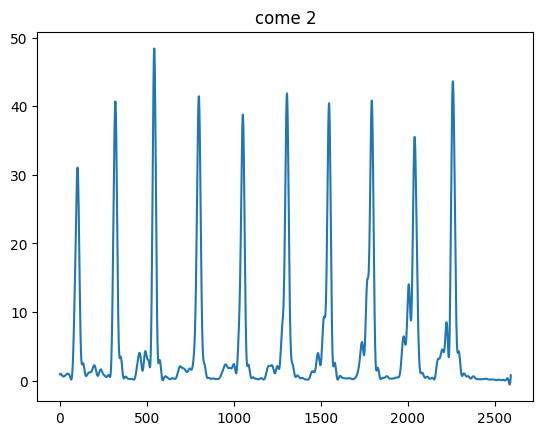

Incorrect peaks in go #1 (3 peaks)


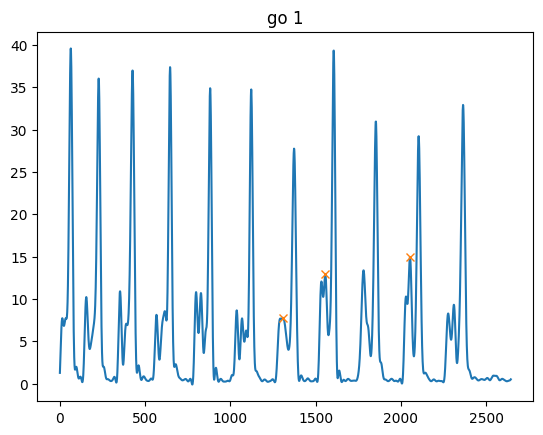

Incorrect peaks in wave #3 (11 peaks)


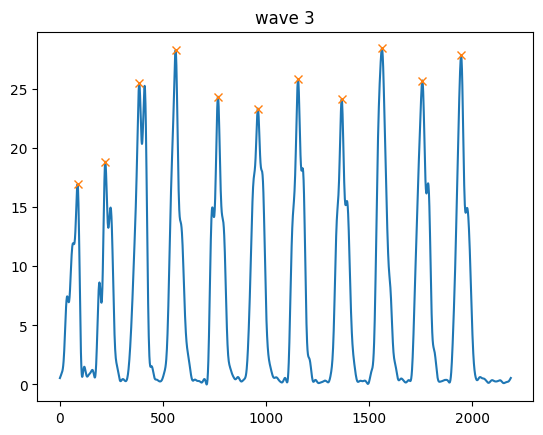

                         accel_x   accel_y   accel_z  accel_abs
gesture gesture_number                                         
circle  0               1.801732  0.700904 -0.767874   2.219752
        0               2.085602  0.641103 -0.860218   2.425969
        0               2.363738  0.553067 -0.987000   2.644976
        0               2.628170  0.434578 -1.150540   2.876423
        0               2.870913  0.283651 -1.351470   3.119950


In [21]:
# Apply the function using the specific parameters
split_gestures_df = split_file_to_gestures(
    filtered_new_unseen,
    threshold=5,
    padding=10,
    height=3,
    distance=20,
    width=30,
    prominence=0
)

print(split_gestures_df.head())


In [23]:
import pandas as pd

# Assuming split_gesture_df is defined somewhere above
def remove_duplicate_gestures(dataframe):
    data = dataframe.copy()
    
    # Define data_columns excluding 'time' which is not necessary for duplicate checking
    data_columns = ['accel_x', 'accel_y', 'accel_z', 'accel_abs']
    group_columns = ['gesture', 'gesture_number']

    grouped = data.groupby(group_columns)

    group_representations = {}
    duplicates_found = False
    for name, group in grouped:
        group_tuple = tuple(group.sort_values(by=data_columns)[data_columns].itertuples(index=False, name=None))
        
        if group_tuple in group_representations:
            duplicates_found = True
            data = data.drop(group.index)  # Make sure to drop by index correctly
            print("Removing identical gestures", name, "and", group_representations[group_tuple])
        group_representations[group_tuple] = name
        
    if not duplicates_found:
        print("No duplicate gestures found")
    return data

# Example usage with your DataFrame
cleaned_gesture_df = remove_duplicate_gestures(split_gestures_df)
print(cleaned_gesture_df.head())


No duplicate gestures found
                         accel_x   accel_y   accel_z  accel_abs
gesture gesture_number                                         
circle  0               1.801732  0.700904 -0.767874   2.219752
        0               2.085602  0.641103 -0.860218   2.425969
        0               2.363738  0.553067 -0.987000   2.644976
        0               2.628170  0.434578 -1.150540   2.876423
        0               2.870913  0.283651 -1.351470   3.119950


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import os
import random

# Set seed for reproducibility
np.random.seed(38)
random.seed(38)
tf.random.set_seed(38)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Assuming gesture_df is defined and loaded with data
cleaned_gesture_df.reset_index(inplace=True)

# Count the number of unique gestures and convert gestures to categorical labels
N = cleaned_gesture_df['gesture'].nunique()
cleaned_gesture_df['label'] = cleaned_gesture_df['gesture'].astype('category').cat.codes

# Group data by 'gesture' and 'gesture_number', if these columns are part of the DataFrame
grouped = cleaned_gesture_df.groupby(['gesture', 'gesture_number'])
sequences = [group[1][['accel_x', 'accel_y', 'accel_z', 'accel_abs']].values for group in grouped]
labels = [group[1]['label'].iloc[0] for group in grouped]

# Convert labels to categorical
y = to_categorical(labels, num_classes=N)

# Pad the sequences so they are all the same length
X = pad_sequences(sequences, padding='post', dtype='float32')

# Define and compile the GRU model
timesteps = X.shape[2]  # Timesteps per sequence
features = X.shape[2]  # Features per timestep

model = Sequential([
    GRU(64, input_shape=(timesteps, features), return_sequences=True),
    GRU(32),
    Dense(N, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the entire dataset with a validation split
history = model.fit(X, y, epochs=25, batch_size=10, validation_split=0.1)

# Evaluate model performance using the validation part of the dataset
# Since we're training on all data, the validation acts as our test
val_loss, val_acc = model.evaluate(X, y)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')



Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.3893 - loss: 1.1822 - val_accuracy: 0.3333 - val_loss: 1.0733
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6958 - loss: 1.0304 - val_accuracy: 0.0000e+00 - val_loss: 1.0661
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4506 - loss: 0.9127 - val_accuracy: 0.0000e+00 - val_loss: 1.0628
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4506 - loss: 0.8200 - val_accuracy: 0.0000e+00 - val_loss: 1.0659
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4506 - loss: 0.7574 - val_accuracy: 0.0000e+00 - val_loss: 1.0806
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4506 - loss: 0.7278 - val_accuracy: 0.0000e+00 - val_loss: 1.1142
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4506 - loss: 0.7223 - val_accuracy: 0.0000e+00 - val_loss: 1.1678
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4506 - loss: 0.7246 - val_accuracy: 0.0000e+00 -